In [1]:
# coding: utf-8
import torch
import torch.nn.functional as F

import numpy
import pandas

from nnsight import LanguageModel, apply

from sklearn.metrics.pairwise import cosine_distances
import matplotlib.pyplot as plt
import seaborn

In [2]:
def calc_distances(x, y):
    # cosine similarity = normalize the vectors & multiply
    return torch.diagonal(1 - (F.normalize(x.detach().squeeze(0)[:-1], dim=-1) @ F.normalize(y.detach().squeeze(0)[:-1],dim=-1).t()))
    
def forwardpass (model, prompt, tokens):
    layers = model.backbone.blocks
    # run the text through the model to get the baseline to
    # calculate the differences against
    with model.trace() as tracer:
        hidden_state = []
        with tracer.invoke(prompt) as invoker:
            for layer_ix in range(32):
                layer = getattr(layers, str(layer_ix))
                if layer_ix == 0:
                    layer_input = layer.input.clone().save()
                    hidden_state.append(layer_input)
                layer_output = layer.output.save()
                hidden_state.append(layer_output)

    vz_results = []
    with model.trace() as tracer:
        for token_ix in range(len(tokens)):
            token_vz_results = []
            for head_ix in range(model.config.num_heads):
                head_dim = model.config.embedding_dim // model.config.num_heads
                head_vz_results = []
                with tracer.invoke(prompt) as invoker:
                    for layer_ix in range(32):
                        layer = getattr(layers, str(layer_ix))
                        layer.input[0] = hidden_state[layer_ix][0]
                        layer_v = getattr(getattr(layer, "mlstm_layer"), "v")
                        v_output = layer_v.output
                        v_output[0,token_ix,(head_ix*head_dim):((head_ix+1)*head_dim)] = torch.zeros(1, head_dim)
                        layer_output = layer.output
                        dists = apply(calc_distances, layer_output[0], hidden_state[layer_ix+1][0]).save()
                        head_vz_results.append(dists)
                token_vz_results.append(head_vz_results)
            vz_results.append(token_vz_results)
    return hidden_state, vz_results

In [3]:
model = LanguageModel("NX-AI/xLSTM-7b", device_map="cuda")


In [4]:
tokenizer = model.tokenizer

In [5]:
#prompt = "Sarah told the author about her book"
prompt = "The clown is playing his show tonight in the circus"
#prompt = '"I am going home," he said'
#prompt = 'Elizabeth Warren (D-MA) says she disagrees with the policies'
#prompt = 'the sum of 5 and 8 is 13'

inputs = tokenizer(prompt, add_special_tokens=True)
hidden_state, vz_hidden_state = forwardpass(model, prompt, inputs['input_ids'])


Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

You're using a GPTNeoXTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [6]:
token_vz = torch.stack([torch.stack([torch.stack([vvv[:] for vvv in vv]) for vv in v]) for v in vz_hidden_state])

In [7]:
token_vz = token_vz.transpose(2,0).transpose(2,3)
print(token_vz.shape)

torch.Size([32, 8, 10, 10])


In [8]:
seq_length = token_vz.shape[-1]

In [9]:
vmax = token_vz.max()
print(vmax)

tensor(0.0557, device='cuda:0')


In [10]:
input_words = tokenizer.convert_ids_to_tokens(inputs['input_ids'])
corr_ix = pandas.MultiIndex.from_product(
    [
        range(32),
        range(8),
        range(len(input_words)),
        range(len(input_words)),
    ], 
    names=['layer', 'head', 'token_hs', 'token_vz'])
corr_df = pandas.DataFrame(token_vz.flatten().cpu(), columns=['activation_corr'], index=corr_ix).reset_index()


In [11]:
def draw_heatmap(columns, index, values, data=None, **kwargs):
    d = data.pivot(index=index, columns=columns, values=values)
    seaborn.heatmap(d, **kwargs)

/home/martijn/miniforge3/envs/xlstm_new/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


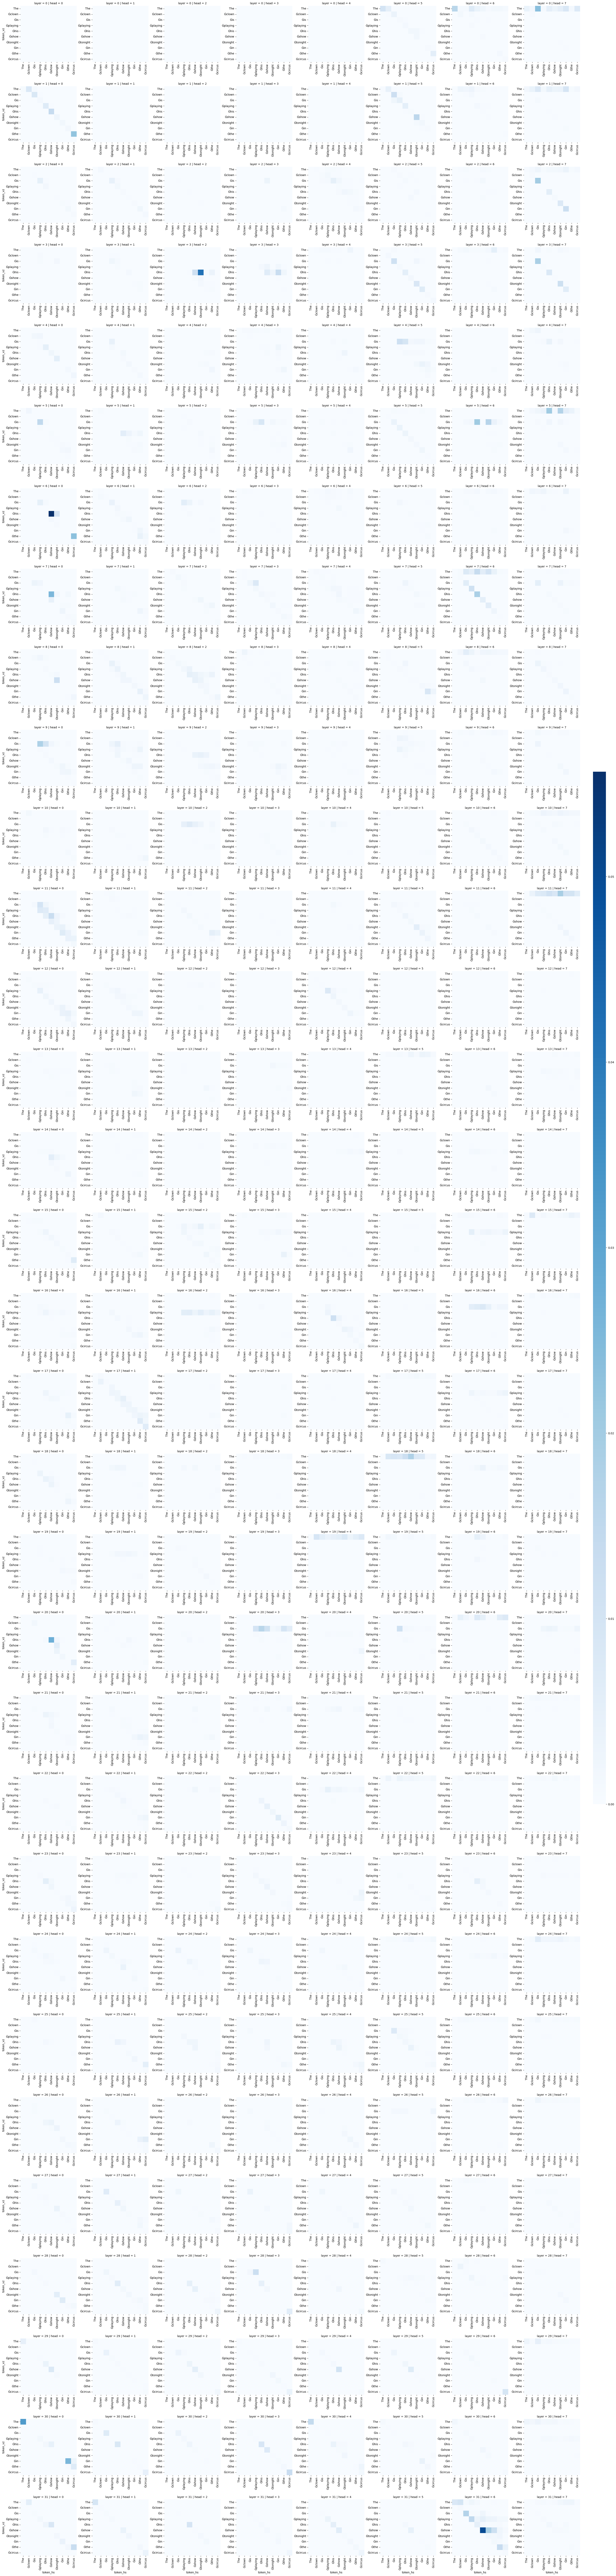

In [12]:
g = seaborn.FacetGrid(data=corr_df, col="head", row="layer", height=4, sharey=False, sharex=False)
cbar_ax = g.fig.add_axes([.92, .3, .02, .4])  # <-- Create a colorbar axes

g.map_dataframe(draw_heatmap, "token_hs", "token_vz", "activation_corr", 
        xticklabels=input_words,
        yticklabels=input_words,
        #annot=True, fmt=".3f",# annot_kws={'size': 'small'},
        cbar_ax=cbar_ax, vmin=0, vmax=vmax,
        cmap="Blues",
        square=True,
    )
g.fig.subplots_adjust(right=.9)  # <-- Add space so the colorbar doesn't overlap the plot